# Подготовка данных в таблице rides

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных

In [2]:
path  = 'data/rides.csv'
df_rides = pd.read_csv(path, sep=',', decimal='.', encoding='utf-8')
df_rides.head()


,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


## Обработка заголовков

In [3]:
df_rides.columns = df_rides.columns.str.lower().str.replace(' ', '_')

print(df_rides.columns)


Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo'],
      dtype='object')


## Удаление дубликатов

In [4]:
df_rides.drop_duplicates(inplace=True)
print(f'Размер датасета после удаления дубликатов: {df_rides.shape}')


Размер датасета после удаления дубликатов: (97372, 9)


## Конвертация времени

In [5]:
# Приведение столбцов времени к формату datetime
df_rides['start_date'] = pd.to_datetime(df_rides['start_date'])
df_rides['end_date'] = pd.to_datetime(df_rides['end_date'])

df_rides.dtypes[['start_date', 'end_date']]


start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

## Функции нормализации текста

In [6]:
def normalize_district(district):
    """Нормализация названий районов: заглавная буква, обработка дефисов."""
    district = district[0].upper() + district[1:].replace(' ', '-', 1)
    if '-' in district:
        words = district.split('-')
        words[1] = words[1][0].upper() + words[1][1:]
        district = '-'.join(words)
    return district

def normalize_location(location):
    """Нормализация локаций: удаление 'ул', лишних символов, приведение регистра."""
    location = location.lower()
    location = location.replace('ул', '', 1).lstrip('. ')
    location = location[0].upper() + location[1:]
    if ' ' in location:
        words = location.split()
        words[1] = words[1][0].upper() + words[1][1:]
        location = ' '.join(words)
    return location


## Применение нормализации

удаляем все приставки "ул" и делаем первые буквы заглавными

In [7]:
# Применение функций к текстовым столбцам
df_rides['start_district'] = df_rides['start_district'].apply(normalize_district)
df_rides['end_district'] = df_rides['end_district'].apply(normalize_district)

df_rides['start_location'] = df_rides['start_location'].apply(normalize_location)
df_rides['end_location'] = df_rides['end_location'].apply(normalize_location)

# Проверка случайной выборки
df_rides[['start_district', 'start_location']].sample(5)


,start_district,start_location
30079,Северо-Западный,Строительная
49547,Центральный,Советская
32744,Центральный,Гагарина
16999,Юго-Восточный,Юбилейная
69088,Октябрьский,Ломоносова


## Расчет длительности и фильтрация временных аномалий

In [8]:
# 1. Расчет длительности поездки в секундах
df_rides['duration'] = (df_rides['end_date'] - df_rides['start_date']).dt.total_seconds()

# 2. Определение масок для аномалий
mask_negative_duration = df_rides['end_date'] < df_rides['start_date']
mask_too_short = df_rides['duration'] < 60       # Менее 1 минуты
mask_too_long = df_rides['duration'] > 7 * 3600  # Более 7 часов

# 3. Фильтрация
print(f"Удалено записей с аномальным временем: {(mask_negative_duration | mask_too_short | mask_too_long).sum()}")
duration_outliers_mask = mask_negative_duration | mask_too_short | mask_too_long
df_rides = df_rides[~duration_outliers_mask].copy()

# 4. КОНСТАНТЫ (выбраны исходя из графиков)
MIN_DISTANCE = 10 # 10 метров
MAX_DISTANCE = 60000 # 60 км

Удалено записей с аномальным временем: 0


удаляем слишком длиные и слишком короткие поездки

заметили, что данные разбиты на 3 группы, с похожим распределением: от 0 до 10 метров, от 500 до 10000, от 1000000 до 10000000

## Фильтрация аномалий дистанции по нижней границе

количество поездок с расстоянием < 10м:  2939


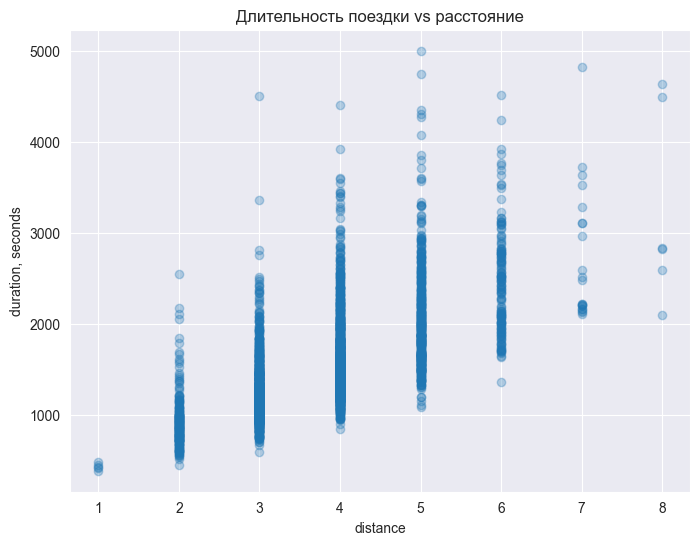

In [9]:
rides_trim_min = df_rides[df_rides['distance'] <= MIN_DISTANCE]

print('количество поездок с расстоянием < 10м: ', rides_trim_min['distance'].count())

plt.figure(figsize=(8, 6))
plt.scatter(rides_trim_min['distance'], rides_trim_min['duration'], alpha=0.3)
plt.xlabel('distance')
plt.ylabel('duration, seconds')
plt.title('Длительность поездки vs расстояние')
plt.show()

## Фильтрация нормальных поездок

количество поездок с расстоянием от 10м до 20000м:  92659


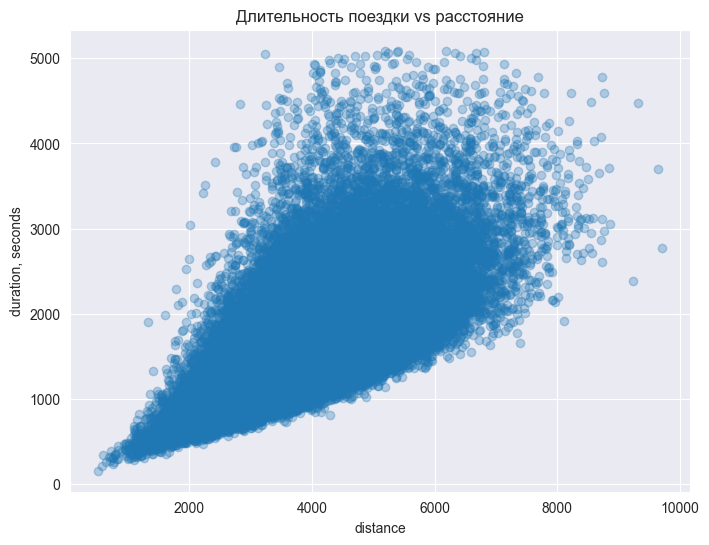

In [10]:
rides_trim = df_rides[(df_rides['distance'] <= MAX_DISTANCE) & (df_rides['distance'] > MIN_DISTANCE)]

print('количество поездок с расстоянием от 10м до 20000м: ', rides_trim['distance'].count())

plt.figure(figsize=(8, 6))
plt.scatter(rides_trim['distance'], rides_trim['duration'], alpha=0.3)
plt.xlabel('distance')
plt.ylabel('duration, seconds')
plt.title('Длительность поездки vs расстояние')
plt.show()

## Фильтрация аномалий дистанции по верхней границе

количество поездок с расстоянием > 60000м: 593


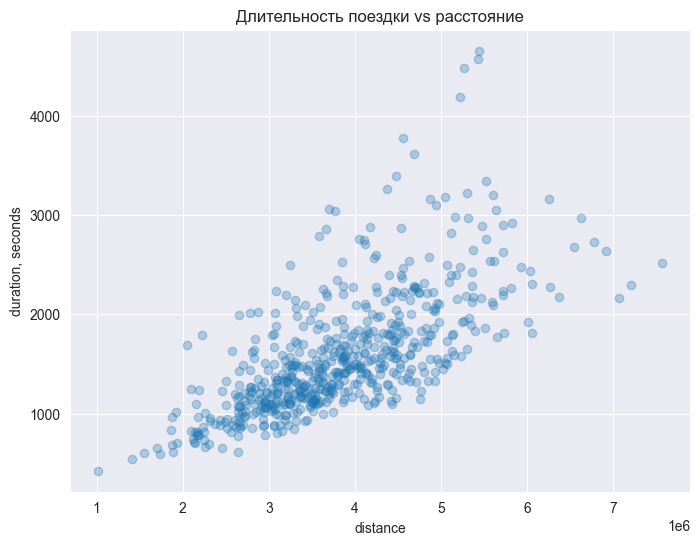

In [11]:
rides_trim_max = df_rides[df_rides['distance'] > MAX_DISTANCE]

print(f"количество поездок с расстоянием > {MAX_DISTANCE}м: {rides_trim_max['distance'].count()}")

plt.figure(figsize=(8, 6))
plt.scatter(rides_trim_max['distance'], rides_trim_max['duration'], alpha=0.3)
plt.xlabel('distance')
plt.ylabel('duration, seconds')
plt.title('Длительность поездки vs расстояние')
plt.show()

## Анализ распределения аномалий

In [12]:
# 1. Выделим аномалии (пример с distance)
mask_anomaly = (df_rides['distance'] < MIN_DISTANCE) | (df_rides['distance'] > MAX_DISTANCE)

# Добавляем маску как колонку
df_rides['is_anomaly'] = mask_anomaly.astype(int)

print(f"Всего аномалий: {mask_anomaly.sum()} ({mask_anomaly.sum() / len(df_rides) * 100:.2f}%)")
print()

# 2. Проверка по дням недели
print("=== Распределение аномалий по дням недели ===")
df_rides['day_of_week'] = df_rides['start_date'].dt.dayofweek

# Считаем долю аномалий для каждого дня
day_stats = df_rides.groupby('day_of_week').agg(
    total=('distance', 'count'),
    anomalies=('is_anomaly', 'sum')
)
day_stats['anomaly_rate_%'] = (day_stats['anomalies'] / day_stats['total'] * 100).round(2)

# Названия дней
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
day_stats.index = day_stats.index.map(lambda x: day_names[x])

print(day_stats)
print(f"\nМакс. разница в долях: {day_stats['anomaly_rate_%'].max() - day_stats['anomaly_rate_%'].min():.2f}%")
print()

# 3. Проверка по маршрутам (топ-20)
print("=== Распределение аномалий по маршрутам (топ-20) ===")
df_rides['route'] = df_rides['start_location'] + ' → ' + df_rides['end_location']

route_stats = df_rides.groupby('route').agg(
    total=('distance', 'count'),
    anomalies=('is_anomaly', 'sum')
)
route_stats['anomaly_rate_%'] = (route_stats['anomalies'] / route_stats['total'] * 100).round(2)

# Топ-20 маршрутов по количеству поездок
top_routes = route_stats.nlargest(20, 'total')
print(top_routes)
print(f"\nСредняя доля аномалий на топ-маршрутах: {top_routes['anomaly_rate_%'].mean():.2f}%")
print()

# 4. Проверка по районам
print("=== Распределение аномалий по районам отправления ===")
district_stats = df_rides.groupby('start_district').agg(
    total=('distance', 'count'),
    anomalies=('is_anomaly', 'sum')
)
district_stats['anomaly_rate_%'] = (district_stats['anomalies'] / district_stats['total'] * 100).round(2)
district_stats = district_stats.sort_values('anomaly_rate_%', ascending=False)

print(district_stats)
print(f"\nМакс. разница в долях по районам: {district_stats['anomaly_rate_%'].max() - district_stats['anomaly_rate_%'].min():.2f}%")
print()


Всего аномалий: 3532 (3.63%)

=== Распределение аномалий по дням недели ===
             total  anomalies  anomaly_rate_%
day_of_week                                  
Пн           12581        447            3.55
Вт           11061        411            3.72
Ср           11520        409            3.55
Чт           11393        400            3.51
Пт           13927        525            3.77
Сб           17772        655            3.69
Вс           17937        685            3.82

Макс. разница в долях: 0.31%

=== Распределение аномалий по маршрутам (топ-20) ===
                         total  anomalies  anomaly_rate_%
route                                                    
Буденного → Буденного       67          3            4.48
Луговая → Спортивная        67          1            1.49
Майская → Спортивная        61          1            1.64
Спортивная → Майская        60          4            6.67
Восточная → Луговая         58          1            1.72
Ломоносова → Спортив

Визуализация анализа

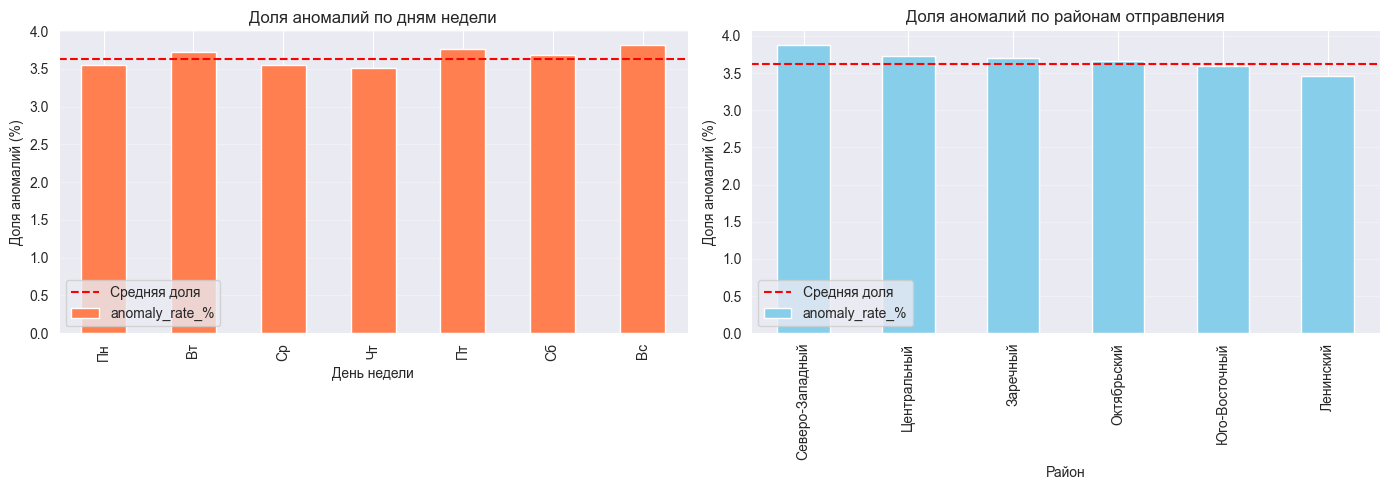

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График по дням недели
day_stats['anomaly_rate_%'].plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title('Доля аномалий по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Доля аномалий (%)')
axes[0].axhline(y=mask_anomaly.sum() / len(df_rides) * 100, color='red', 
                linestyle='--', label='Средняя доля')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# График по районам
district_stats['anomaly_rate_%'].plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Доля аномалий по районам отправления')
axes[1].set_xlabel('Район')
axes[1].set_ylabel('Доля аномалий (%)')
axes[1].axhline(y=mask_anomaly.sum() / len(df_rides) * 100, color='red', 
                linestyle='--', label='Средняя доля')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

нижние и верхние границы выбросов распределенны равномерно по районам и дням недели и не превышают 4%, а значит их удаление не повлияет на анализ

Оставим только среднюю, наибольшую часть

## Восстановление данных длительности поездки от медианной скорости

In [14]:
# Удаление выбросов по дистанции
mask_zero_negative_distance = df_rides['distance'] <= 0
mask_too_short_distance = df_rides['distance'] < MIN_DISTANCE  # < 10м
mask_too_long_distance = df_rides['distance'] > MAX_DISTANCE  # > 60км

distance_outliers_mask = (
    mask_zero_negative_distance | 
    mask_too_short_distance | 
    mask_too_long_distance
)
df_rides = df_rides[~distance_outliers_mask].copy()

In [15]:
# Восстановление длительности
def restore_duration(group):
    mask = group['duration'].isna()
    
    if mask.sum() == 0:
        return group
    
    correct_rides = group[~mask]
    
    if len(correct_rides) == 0:
        return group
    
    # Медианная скорость теперь на ЧИСТЫХ данных!
    median_speed = (correct_rides['distance'] / correct_rides['duration']).median()
    
    group.loc[mask, 'duration'] = group.loc[mask, 'distance'] / median_speed
    group.loc[mask, 'end_date'] = pd.to_datetime(
        group.loc[mask, 'start_date'] + pd.to_timedelta(group.loc[mask, 'duration'], unit='s')
    )
    
    return group

df_rides['group_key'] = df_rides.apply(
    lambda x: frozenset([x['start_location'], x['end_location']]),
    axis=1
)

df_rides = df_rides.groupby('group_key', group_keys=False).apply(restore_duration, include_groups=False)
print(f"Осталось NaN в duration: {df_rides['duration'].isna().sum()}")


Осталось NaN в duration: 0


In [16]:
# Восстановление дистанции
def restore_distance(group):
    mask = group['distance'].isna()
    
    if mask.sum() == 0:
        return group
    
    correct_rides = group[~mask]
    
    if len(correct_rides) == 0:
        return group
    
    median_speed = (correct_rides['distance'] / correct_rides['duration']).median()
    group.loc[mask, 'distance'] = median_speed * group.loc[mask, 'duration']
    
    return group

df_rides['group_key'] = df_rides.apply(
    lambda x: frozenset([x['start_location'], x['end_location']]),
    axis=1
)

df_rides = df_rides.groupby('group_key', group_keys=False).apply(restore_distance, include_groups=False)


In [17]:
# Удаление невосстановимых
both_nan_mask = df_rides['distance'].isna() & df_rides['duration'].isna()
df_rides = df_rides[~both_nan_mask]


Подсчет и удаление всех NaN / NaT

In [18]:

# Сколько пропусков всего в датафрейме
total_nans = df_rides.isna().sum().sum()
print(f'Всего пропусков (NaN/NaT): {total_nans}')

# Сколько пропусков по каждому столбцу
print('Пропуски по столбцам:')
print(df_rides.isna().sum())

# Удаляем все строки с любыми пропусками
df_rides = df_rides.dropna().copy()

print(f'Размер после удаления пропусков: {df_rides.shape}')


Всего пропусков (NaN/NaT): 0
Пропуски по столбцам:
id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
duration          0
is_anomaly        0
day_of_week       0
route             0
dtype: int64
Размер после удаления пропусков: (93840, 13)


Проверка промокодов

In [19]:
# промокоды должны быть только по понедельникам 6-10
mask_promo_correct = (
    (df_rides['promo'] == 1) & 
    (df_rides['start_date'].dt.dayofweek == 0) &
    (df_rides['start_date'].dt.hour >= 6) &
    (df_rides['start_date'].dt.hour < 10)
)
print(f"Корректных промо: {mask_promo_correct.sum()}")
print(f"Всего промо: {(df_rides['promo'] == 1).sum()}")


Корректных промо: 1845
Всего промо: 1845


# Финальная очистка и сохранение

In [20]:
# Сохранение результата
df_rides.to_csv('data/processing_rides.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')
print("Файл processing_rides.csv успешно сохранен.")

Файл processing_rides.csv успешно сохранен.


Финальные даннные

In [21]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,is_anomaly,day_of_week,route
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0,1422.0,0,5,Шевченко → Майская
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0,1705.0,0,5,Чехова → Спортивная
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0,2299.0,0,5,Буденного → Суворова
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0,1909.0,0,5,Труда → Рабочая
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0,1840.0,0,5,Первомайская → Юбилейная
